Import libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import pickle
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_score, KFold
import joblib
import warnings
warnings.filterwarnings('ignore')

Data Loading & Preprocessing

In [50]:
# Load dataset
df = pd.read_csv("Flight_Price.csv")

# Show initial data
print("Shape of data:", df.shape)
df.head()

Shape of data: (10683, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [52]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [53]:
df.dropna(inplace=True)

In [54]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [55]:
df.duplicated().sum()

np.int64(220)

In [56]:
df.drop_duplicates(inplace=True)

In [57]:
# Show available columns to verify actual names
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

Handling Outliers

In [58]:
numerical_cols = df.select_dtypes(exclude='object').columns
numerical_cols

Index(['Price'], dtype='object')

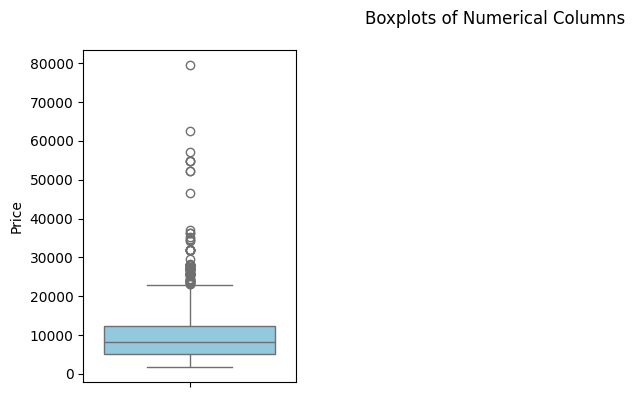

In [59]:
plt.figure(figsize=(10, 4))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

There is a possibility of high flight prices for some airlines in both business and economy classes. Since there are some outliers in the price feature, I replaced values greater than or equal to 40K with the median.

In [60]:
df['Price']=np.where(df['Price']>=40000,df['Price'].median(),df['Price'])

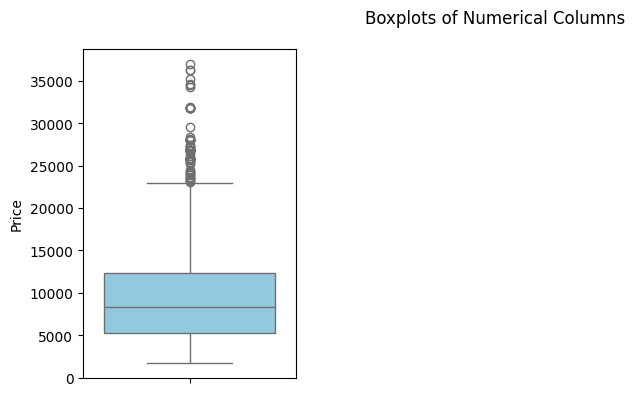

In [61]:
plt.figure(figsize=(10, 4))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

Feature Engineering

In [62]:
# Convert date and time columns
df['Journey_Day'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.day                                 
df['Journey_Month'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.month

In [63]:
df['Dep_hour'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour
df['Dep_min'] = pd.to_datetime(df['Dep_Time'],format='%H:%M').dt.minute

In [64]:
df['Arrival_Time'] = df['Arrival_Time'].str.split(" ").str[0]
df['Arr_hour'] = pd.to_datetime(df['Arrival_Time'],format='%H:%M').dt.hour
df['Arr_min'] = pd.to_datetime(df['Arrival_Time'],format='%H:%M').dt.minute

In [65]:
df['Duration_hours']=  df['Duration'].str.replace("h", '*1').str.replace(' ','+').str.replace('m','/60').apply(eval).round(2)

In [66]:
df['Duration_mins'] = (df['Duration_hours']*60).astype(int)

In [67]:
df['Price_per_minute'] = df['Price'] / df['Duration_mins']

In [68]:
# Drop unnecessary columns
columns_to_drop = ['Date_of_Journey', 'Route','Additional_Info', 'Dep_Time', 'Arrival_Time', 'Duration']
existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop the columns if they exist
df.drop(existing_cols_to_drop, axis=1, inplace=True)

In [69]:
new_df = df.copy()

In [70]:
new_df.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,Price_per_minute
0,IndiGo,Banglore,New Delhi,non-stop,3897.0,24,3,22,20,1,10,2.83,169,23.059172
1,Air India,Kolkata,Banglore,2 stops,7662.0,1,5,5,50,13,15,7.42,445,17.217978
2,Jet Airways,Delhi,Cochin,2 stops,13882.0,9,6,9,25,4,25,19.00,1140,12.177193
3,IndiGo,Kolkata,Banglore,1 stop,6218.0,12,5,18,5,23,30,5.42,325,19.132308
4,IndiGo,Banglore,New Delhi,1 stop,13302.0,1,3,16,50,21,35,4.75,285,46.673684


Handling Categorical Data

In [71]:
#Finding the categorical value
column=[column for column in df.columns if df[column].dtype=='object']
column

['Airline', 'Source', 'Destination', 'Total_Stops']

In [72]:
#Finding the continuous value
continuous_col =[column for column in df.columns if df[column].dtype!='object']
continuous_col

['Price',
 'Journey_Day',
 'Journey_Month',
 'Dep_hour',
 'Dep_min',
 'Arr_hour',
 'Arr_min',
 'Duration_hours',
 'Duration_mins',
 'Price_per_minute']

In [73]:
df[column].head()

,Airline,Source,Destination,Total_Stops
0,IndiGo,Banglore,New Delhi,non-stop
1,Air India,Kolkata,Banglore,2 stops
2,Jet Airways,Delhi,Cochin,2 stops
3,IndiGo,Kolkata,Banglore,1 stop
4,IndiGo,Banglore,New Delhi,1 stop


In [74]:
# One-Hot Encoding 

df = pd.get_dummies(df, columns = ['Airline', 'Source', 'Destination'], dtype = 'int')

In [75]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [76]:
# Categorical encoding
df['Total_Stops'] = df['Total_Stops'].map({
'non-stop': 0,
'1 stop': 1,
'2 stops': 2,
'3 stops': 3,
'4 stops': 4})

In [77]:
pd.set_option('display.max_columns',35)
df.head()

,Total_Stops,Price,Journey_Day,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,Price_per_minute,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897.0,24,3,22,20,1,10,2.83,169,23.059172,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2,7662.0,1,5,5,50,13,15,7.42,445,17.217978,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,2,13882.0,9,6,9,25,4,25,19.00,1140,12.177193,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,1,6218.0,12,5,18,5,23,30,5.42,325,19.132308,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,1,13302.0,1,3,16,50,21,35,4.75,285,46.673684,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


Exploratory Data Analysis (EDA)

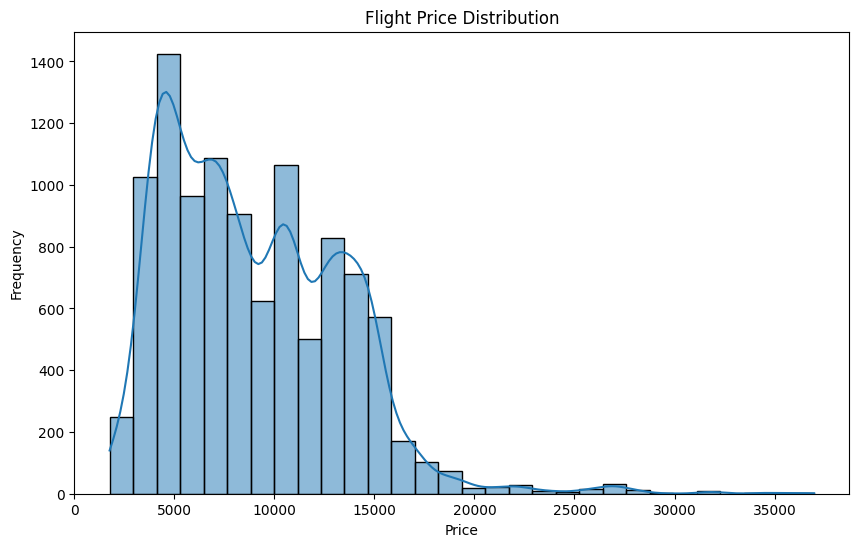

In [78]:
# Plot flight price distribution
plt.figure(figsize=(10, 6))
sns.histplot(new_df['Price'], bins=30, kde=True)
plt.title('Flight Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

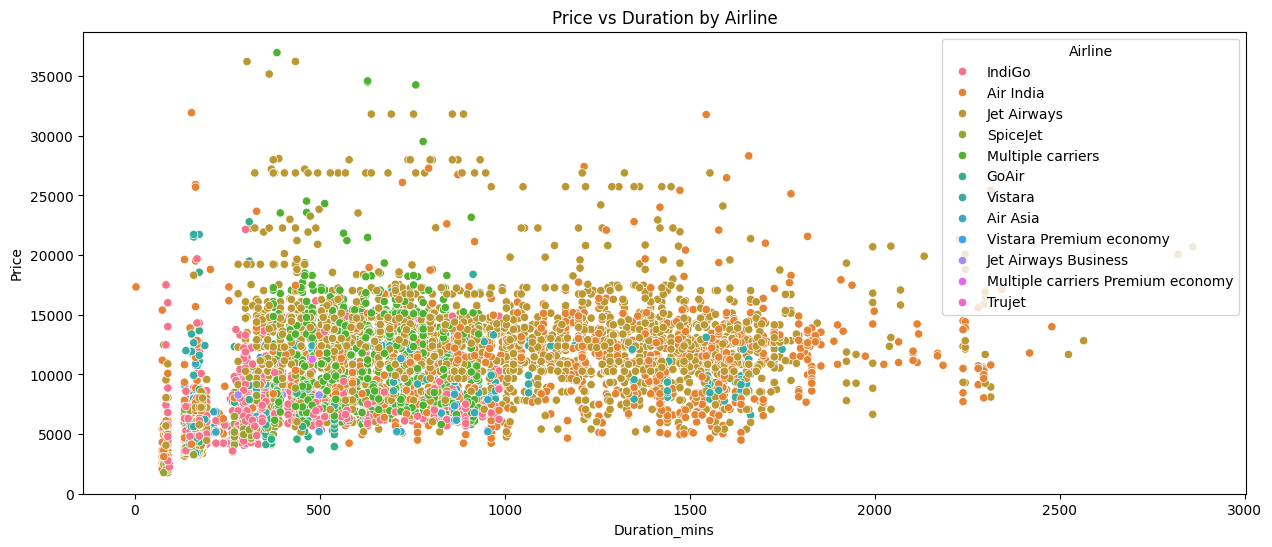

In [79]:
# Price vs Duration by Airline
plt.figure(figsize=(15, 6))
sns.scatterplot(data=new_df, x='Duration_mins', y='Price', hue='Airline')
plt.title('Price vs Duration by Airline')
plt.show()

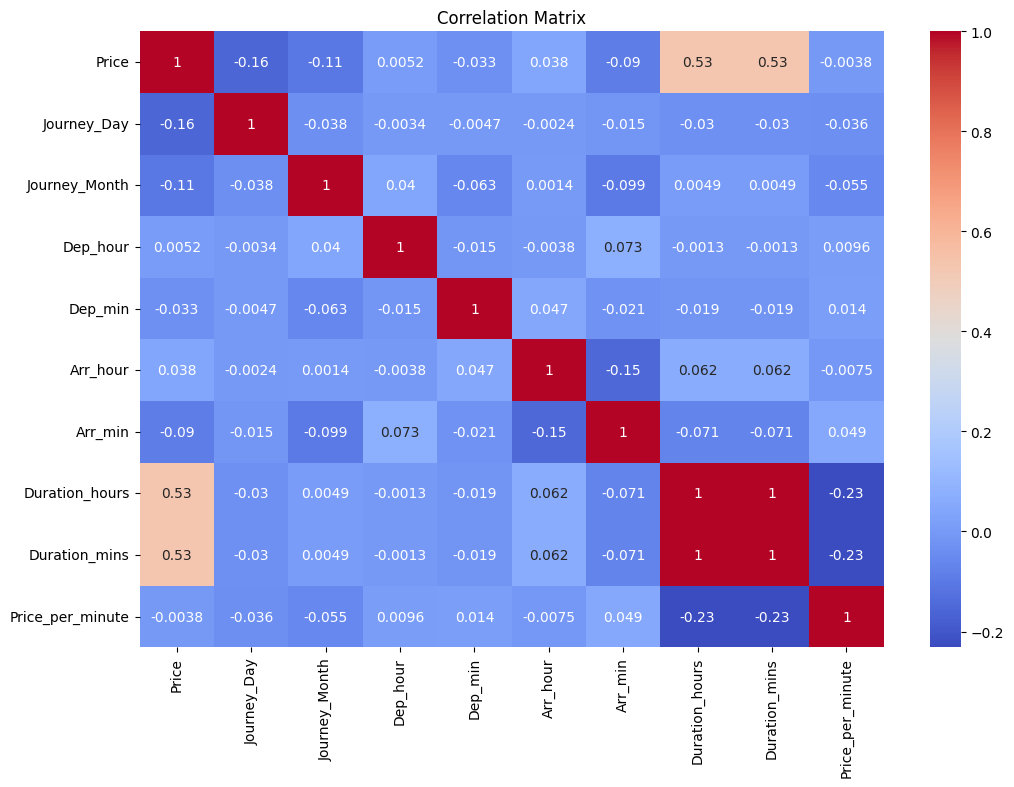

In [80]:
# Correlation heatmap
correlation_matrix = new_df.select_dtypes(exclude='object').corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [81]:
# Top 6 Most Expensive and Cheapest Routes
route_prices = new_df.groupby(['Source', 'Destination'])['Price'].mean().reset_index()
top_expensive = route_prices.nlargest(10, 'Price')
top_cheapest = route_prices.nsmallest(10, 'Price')

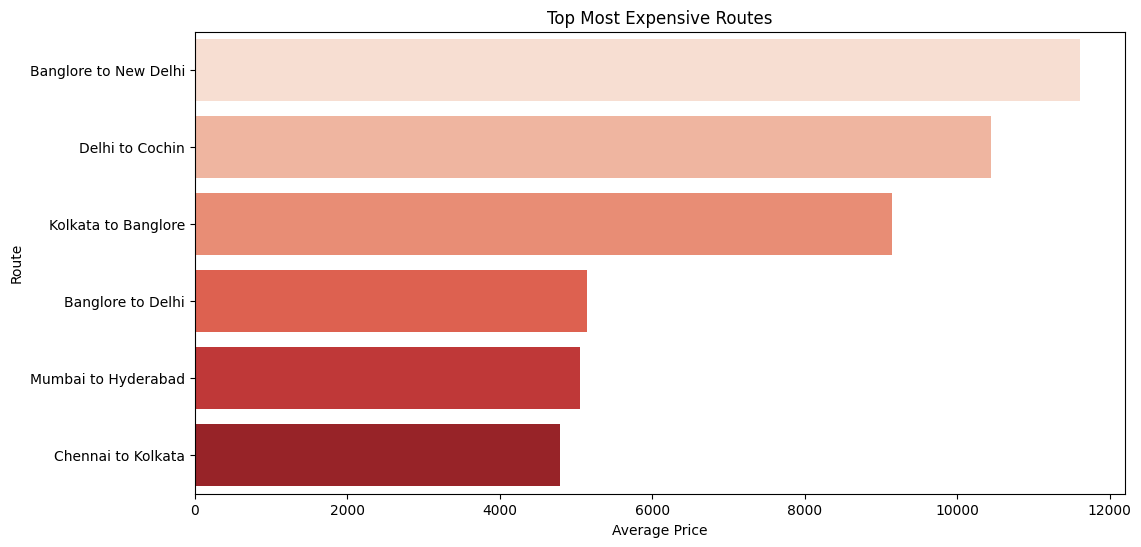

In [82]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_expensive.assign(Route=top_expensive['Source'] + ' to ' + top_expensive['Destination']), palette='Reds')
plt.title('Top Most Expensive Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

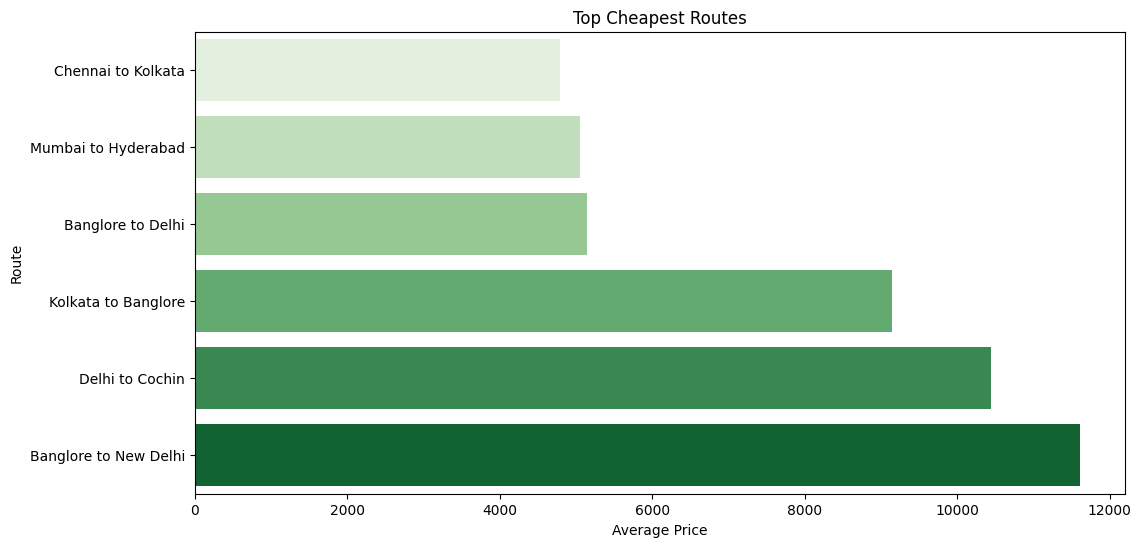

In [83]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_cheapest.assign(Route=top_cheapest['Source'] + ' to ' + top_cheapest['Destination']), palette='Greens')
plt.title('Top Cheapest Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

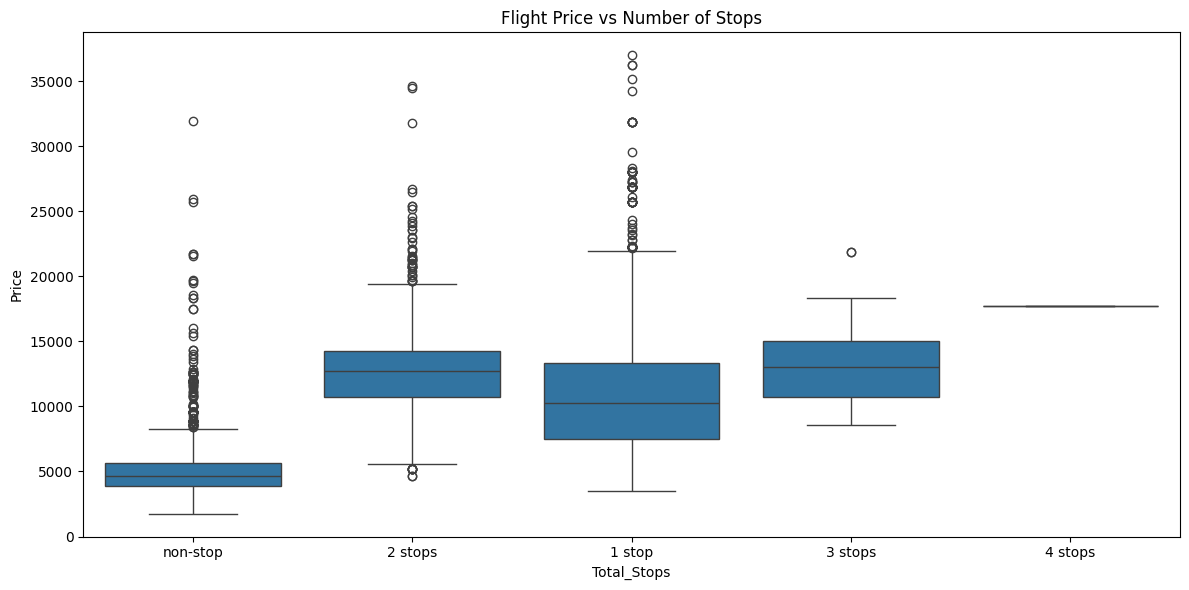

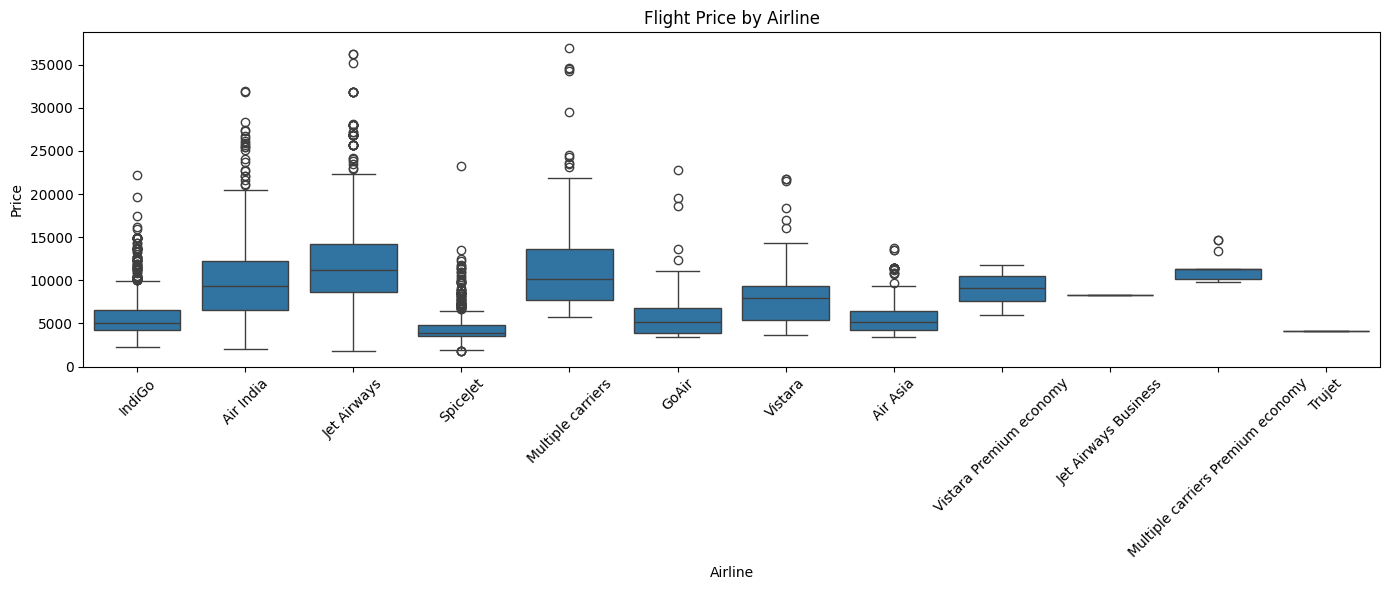

In [84]:
# Boxplots for Categorical Variables
plt.figure(figsize=(12, 6))
sns.boxplot(x='Total_Stops', y='Price', data=new_df)
plt.title("Flight Price vs Number of Stops")
plt.tight_layout()
plt.show()

if 'Airline' in new_df.columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Airline', y='Price', data=new_df)
    plt.title("Flight Price by Airline")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [85]:
# Average Price by source and destination
if 'Source' in new_df.columns and 'Destination' in new_df.columns:
    route_avg = new_df.groupby(['Source', 'Destination'])['Price'].mean().reset_index()
    print("\n Average Price by Route:")
    print(route_avg.sort_values(by='Price', ascending=False).head(10))


 Average Price by Route:
     Source Destination         Price
1  Banglore   New Delhi  11615.743982
3     Delhi      Cochin  10442.672497
4   Kolkata    Banglore   9143.083566
0  Banglore       Delhi   5143.918577
5    Mumbai   Hyderabad   5059.708752
2   Chennai     Kolkata   4789.892388


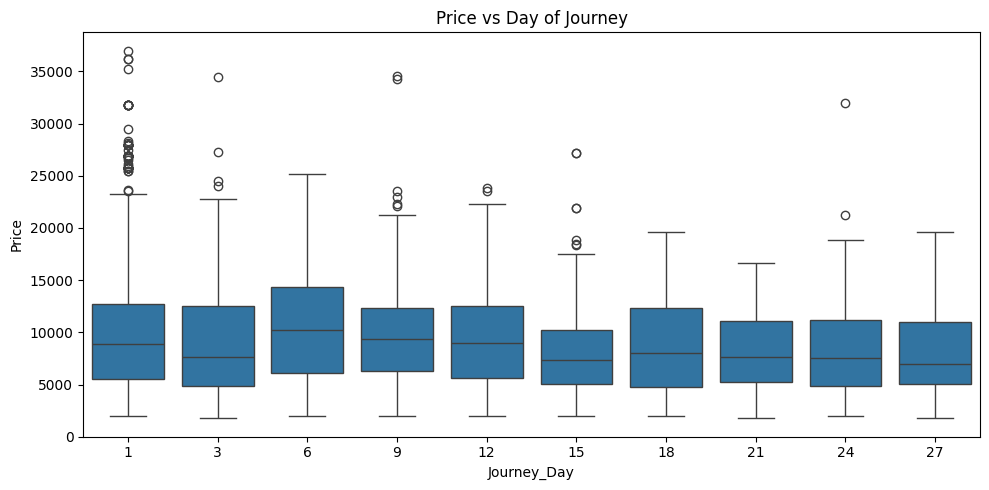

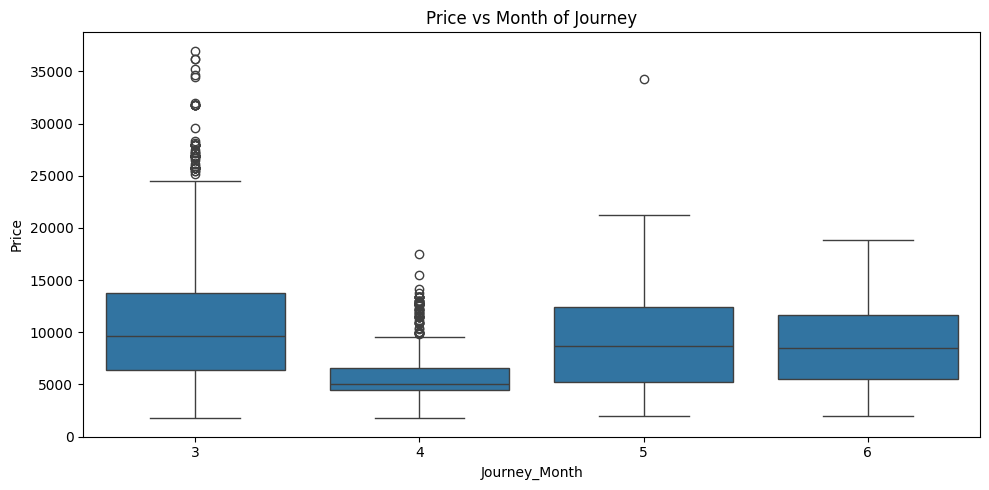

In [86]:
# Price vs Day and Month of Journey
if 'Journey_Day' in new_df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Journey_Day', y='Price', data=new_df)
    plt.title("Price vs Day of Journey")
    plt.tight_layout()
    plt.show()

if 'Journey_Month' in new_df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Journey_Month', y='Price', data=new_df)
    plt.title("Price vs Month of Journey")
    plt.tight_layout()
    plt.show()

ML Flow

In [87]:
# Seperate the dataset in X and Y columns
X=df.drop('Price', axis=1)
y=df['Price']

In [88]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

In [90]:
# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1, 10]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10]
    }
}

In [91]:
# Initialize MLflow
mlflow.set_experiment("Flight Price Prediction")

<Experiment: artifact_location='file:///c:/Users/sophi/OneDrive/Desktop/FlightPrice%26CustomerSatisfactionPrediction/mlruns/991642401674035684', creation_time=1758266885464, experiment_id='991642401674035684', last_update_time=1758266885464, lifecycle_stage='active', name='Flight Price Prediction', tags={}>

In [45]:
mlflow.set_tracking_uri("http://localhost:5000")

In [92]:
trained_models = {}
best_model = None
best_r2 = float('-inf')

Training Linear Regression...

Linear Regression Performance:
  RMSE: 2772.6568
  MAE: 1947.7024
  R² Score: 0.6126
----------------------------------------


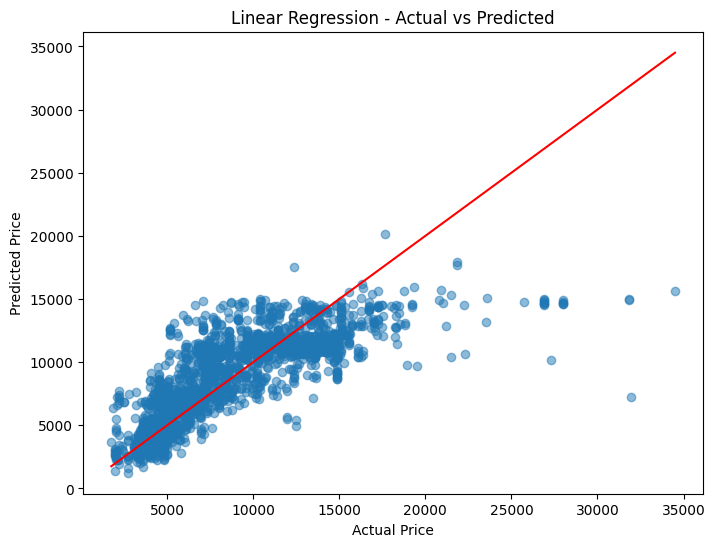

2025/09/19 13:07:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:07:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Linear Regression at: http://localhost:5000/#/experiments/991642401674035684/runs/da27f5e9e6fb40ac907748d8328ea049
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Training Random Forest...

Random Forest Performance:
  RMSE: 395.7887
  MAE: 91.2496
  R² Score: 0.9921
----------------------------------------


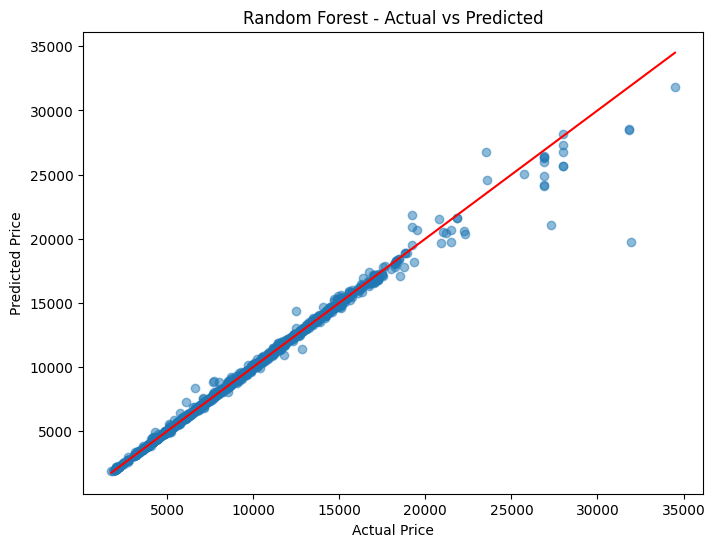

Tuning Random Forest...
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Performance after Tuning:
  RMSE: 382.7263
  MAE: 88.8299
  R² Score: 0.9926
----------------------------------------


2025/09/19 13:09:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:10:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/991642401674035684/runs/14000678fd044d1eb94a3f0c3f0e2606
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Training XGBoost...

XGBoost Performance:
  RMSE: 497.9029
  MAE: 148.2763
  R² Score: 0.9875
----------------------------------------


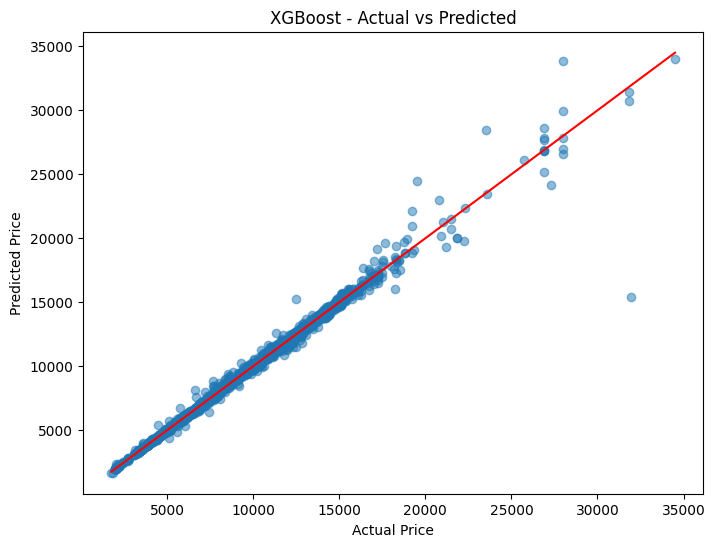

Tuning XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

XGBoost Performance after Tuning:
  RMSE: 470.7174
  MAE: 129.8270
  R² Score: 0.9888
----------------------------------------


2025/09/19 13:10:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:10:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/991642401674035684/runs/e44eb2b27bd5414fa4525a6177c38c4f
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Training Gradient Boosting...

Gradient Boosting Performance:
  RMSE: 614.1697
  MAE: 374.3080
  R² Score: 0.9810
----------------------------------------


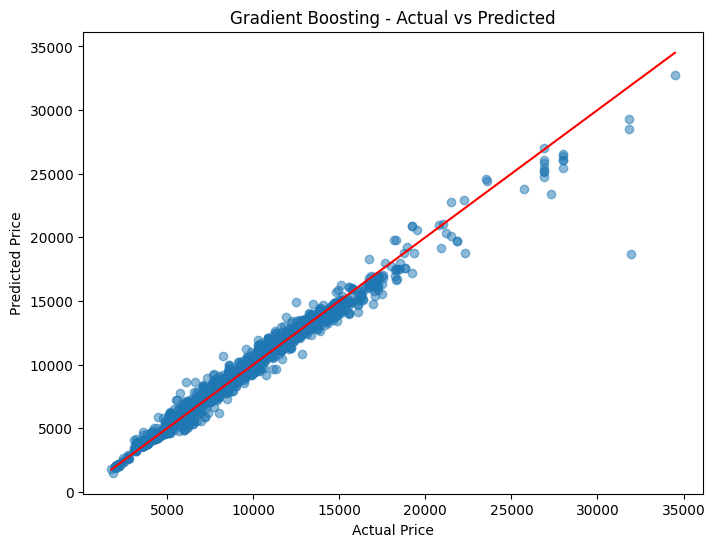

Tuning Gradient Boosting...
Best params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Gradient Boosting Performance after Tuning:
  RMSE: 295.3352
  MAE: 106.0370
  R² Score: 0.9956
----------------------------------------


2025/09/19 13:10:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:10:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/991642401674035684/runs/7e4e1b568dd6430686814bc54b815979
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Training Decision Tree...

Decision Tree Performance:
  RMSE: 666.4187
  MAE: 155.0096
  R² Score: 0.9776
----------------------------------------


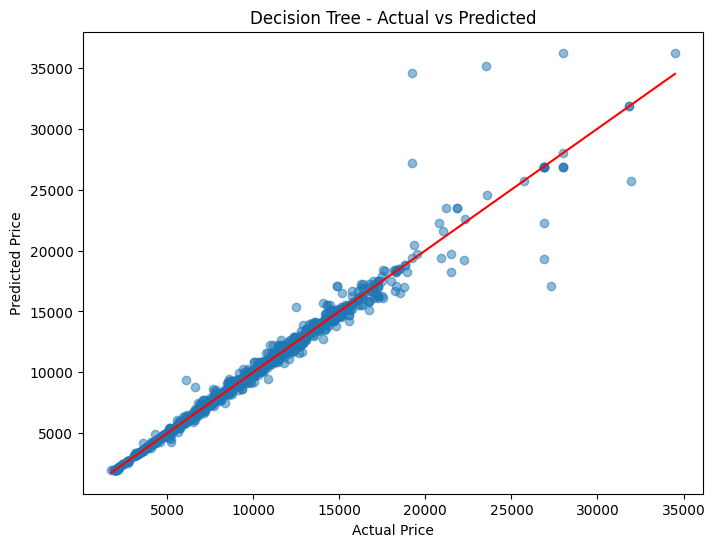

Tuning Decision Tree...
Best params for Decision Tree: {'max_depth': 20}

Decision Tree Performance after Tuning:
  RMSE: 703.4374
  MAE: 160.2176
  R² Score: 0.9751
----------------------------------------


2025/09/19 13:10:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:11:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Decision Tree at: http://localhost:5000/#/experiments/991642401674035684/runs/8a41009346234c3493b5ab2d6209c413
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Training Ridge Regression...

Ridge Regression Performance:
  RMSE: 2773.5823
  MAE: 1948.3697
  R² Score: 0.6123
----------------------------------------


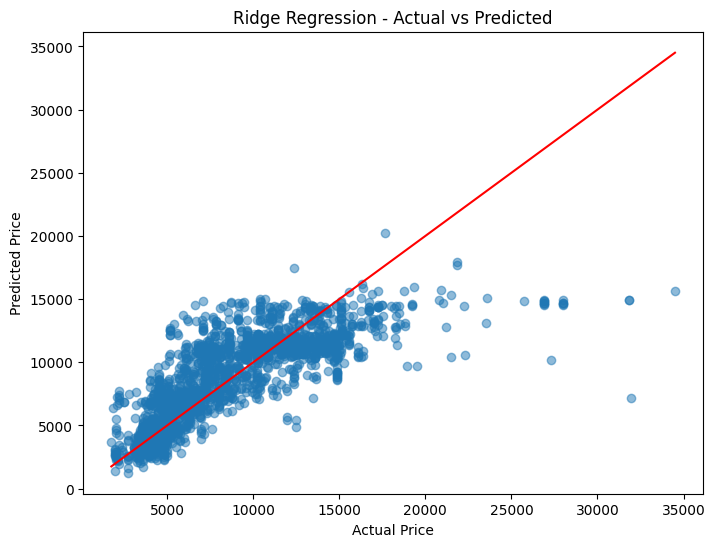

Tuning Ridge Regression...
Best params for Ridge Regression: {'alpha': 0.1}

Ridge Regression Performance after Tuning:
  RMSE: 2772.9376
  MAE: 1947.9483
  R² Score: 0.6125
----------------------------------------


2025/09/19 13:11:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:11:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge Regression at: http://localhost:5000/#/experiments/991642401674035684/runs/1829f2a3b2bc4cbca6f6e4b4dc1b193e
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Training Lasso Regression...

Lasso Regression Performance:
  RMSE: 2774.3682
  MAE: 1947.9353
  R² Score: 0.6121
----------------------------------------


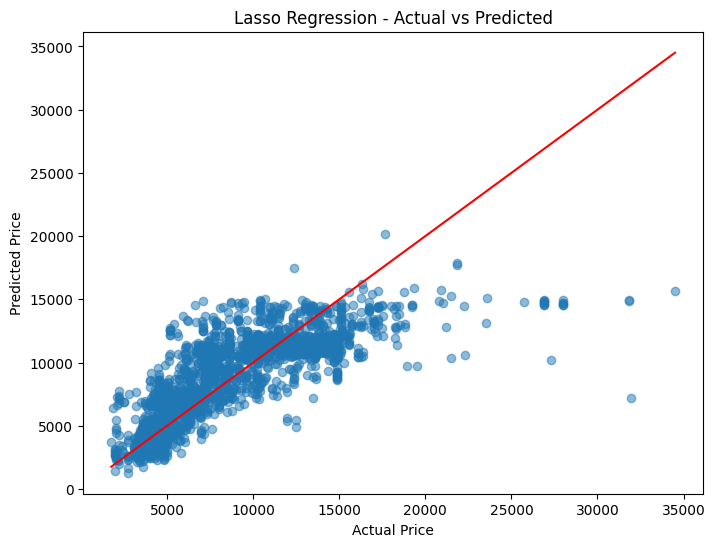

Tuning Lasso Regression...
Best params for Lasso Regression: {'alpha': 0.1}

Lasso Regression Performance after Tuning:
  RMSE: 2773.8502
  MAE: 1948.7769
  R² Score: 0.6123
----------------------------------------


2025/09/19 13:11:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 13:11:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso Regression at: http://localhost:5000/#/experiments/991642401674035684/runs/e118a869f3d442a7bbbef304c3a4d5bb
🧪 View experiment at: http://localhost:5000/#/experiments/991642401674035684
Best Model: Gradient Boosting with R²: 1.00
All models trained, tuned, and logged in MLflow!


In [93]:
# Train, tune, save, and track models
for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 40)

    # Track best model
    if r2 > best_r2:
        best_r2 = r2
        best_model = name

    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{name} - Actual vs Predicted")
    plt.show()

    # Hyperparameter tuning
    if name in param_grids:
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(model, param_grid=param_grids[name], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        model = grid_search.best_estimator_
        y_pred = model.predict(X_test)

        # Re-evaluate
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Best params for {name}: {grid_search.best_params_}")
        print(f"\n{name} Performance after Tuning:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R² Score: {r2:.4f}")
        print("-" * 40)

        if r2 > best_r2:
            best_r2 = r2
            best_model = name

    # MLflow logging
    with mlflow.start_run(run_name=name):
        if name in param_grids:
            for param, value in grid_search.best_params_.items():
                mlflow.log_param(param, value)

        mlflow.log_metrics({"RMSE": rmse, "MAE": mae, "R2": r2})
        mlflow.sklearn.log_model(model, name)

    # Save model
    trained_models[name] = model
    with open(f"{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

print(f"Best Model: {best_model} with R²: {best_r2:.2f}")
print("All models trained, tuned, and logged in MLflow!")

Cross Validation

In [94]:
# Define the model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(gb, X, y, cv=kf, scoring='r2')

# Print all 5 scores
print(f"All 5-Fold Scores: {cv_scores}")
print()
# Compare Mean and Standard Deviation
print(f"Mean R2 Score: {np.mean(cv_scores):.2f}")

All 5-Fold Scores: [0.98099098 0.98145902 0.97890825 0.98287512 0.98393867]

Mean R2 Score: 0.98


In [95]:
# Load the model
model = joblib.load(r"Gradient Boosting_model.pkl")

# Check the model's input features
print(model.feature_names_in_)

['Total_Stops' 'Journey_Day' 'Journey_Month' 'Dep_hour' 'Dep_min'
 'Arr_hour' 'Arr_min' 'Duration_hours' 'Duration_mins' 'Price_per_minute'
 'Airline_Air Asia' 'Airline_Air India' 'Airline_GoAir' 'Airline_IndiGo'
 'Airline_Jet Airways' 'Airline_Jet Airways Business'
 'Airline_Multiple carriers' 'Airline_Multiple carriers Premium economy'
 'Airline_SpiceJet' 'Airline_Trujet' 'Airline_Vistara'
 'Airline_Vistara Premium economy' 'Source_Banglore' 'Source_Chennai'
 'Source_Delhi' 'Source_Kolkata' 'Source_Mumbai' 'Destination_Banglore'
 'Destination_Cochin' 'Destination_Delhi' 'Destination_Hyderabad'
 'Destination_Kolkata' 'Destination_New Delhi']


In [96]:
df.to_csv('cleaned_flight_data.csv', index=False)